In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import xgboost as xgb
import pickle
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = "Earthquake.csv"
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

Dataset Shape: (3000, 19)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      2522 non-null   object 
 1   magnitude  2522 non-null   float64
 2   date_time  2522 non-null   object 
 3   cdi        2522 non-null   float64
 4   mmi        2522 non-null   float64
 5   alert      1118 non-null   object 
 6   tsunami    2522 non-null   float64
 7   sig        2522 non-null   float64
 8   net        2522 non-null   object 
 9   nst        2522 non-null   float64
 10  dmin       2522 non-null   float64
 11  gap        2522 non-null   float64
 12  magType    2522 non-null   object 
 13  depth      2522 non-null   float64
 14  latitude   2522 non-null   float64
 15  longitude  2522 non-null   float64
 16  location   2509 non-null   object 
 17  continent  672 non-null    object 
 18  country    1629 non-null   object 
dtypes: floa

In [47]:
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())


First 5 Rows:
                                      title  magnitude         date_time  cdi  \
0          M 6.5 - 42 km W of Sola, Vanuatu        6.5  16-08-2023 12:47  7.0   
1  M 6.5 - 43 km S of Intipucá, El Salvador        6.5  19-07-2023 00:22  8.0   
2  M 6.6 - 25 km ESE of Loncopué, Argentina        6.6  17-07-2023 03:05  7.0   
3     M 7.2 - 98 km S of Sand Point, Alaska        7.2  16-07-2023 06:48  6.0   
4                  M 7.3 - Alaska Peninsula        7.3  16-07-2023 06:48  0.0   

   mmi   alert  tsunami    sig net    nst      dmin    gap magType    depth  \
0  4.0   green      0.0  657.0  us  114.0  7.177000   25.0     mww  192.955   
1  6.0  yellow      0.0  775.0  us   92.0  0.679000   40.0     mww   69.727   
2  5.0   green      0.0  899.0  us   70.0  1.634000   28.0     mww  171.371   
3  6.0   green      1.0  860.0  us  173.0  0.907000   36.0     mww   32.571   
4  5.0     NaN      1.0  820.0  at   79.0  0.879451  172.8      Mi   21.000   

   latitude  longitude 

In [48]:
# Drop unnecessary columns
df = df.drop(columns=['continent', 'country', 'location', 'title', 'net', 'date_time'])
df = df.dropna(subset=['alert'])  # Drop rows where alert is missing

# Encode categorical features
le_alert = LabelEncoder()
df['alert'] = le_alert.fit_transform(df['alert'])
le_magType = LabelEncoder()
df['magType'] = le_magType.fit_transform(df['magType'])

# Define features and target variables
features = ['cdi', 'mmi', 'sig', 'alert', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude', 'longitude']
X = df[features]

# Targets
y_magnitude = df['magnitude']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for each prediction task
X_train, X_temp, y_mag_train, y_mag_temp = train_test_split(X_scaled, y_magnitude, test_size=0.3, random_state=42)
X_test, X_val, y_mag_test, y_mag_val = train_test_split(X_temp, y_mag_temp, test_size=0.5, random_state=42)

# Train XGBoost for Magnitude Prediction
xgb_mag_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
xgb_mag_model.fit(X_train, y_mag_train)

# Predictions
xgb_mag_pred = xgb_mag_model.predict(X_test)

# Evaluate models
mag_rmse = np.sqrt(mean_squared_error(y_mag_test, xgb_mag_pred))
mag_r2 = r2_score(y_mag_test, xgb_mag_pred)

print(f"XGBoost Magnitude Prediction:\nRMSE: {mag_rmse}\nR² Score: {mag_r2}")

# Train RandomForestRegressor for Magnitude Prediction
rf_mag_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_mag_model.fit(X_train, y_mag_train)

# Predictions
rf_mag_pred = rf_mag_model.predict(X_test)

# Evaluate models
rf_rmse = np.sqrt(mean_squared_error(y_mag_test, rf_mag_pred))
rf_r2 = r2_score(y_mag_test, rf_mag_pred)

print(f"Random Forest Magnitude Prediction:\nRMSE: {rf_rmse}\nR² Score: {rf_r2}")

# Save models
# Save RandomForest model
with open("earthquake_rf_mag.pkl", "wb") as f:
    pickle.dump(rf_mag_model, f)
    
with open("earthquake_xgb_mag.pkl", "wb") as f:
    pickle.dump(xgb_mag_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

XGBoost Magnitude Prediction:
RMSE: 0.09979439409566628
R² Score: 0.9439925659140828
Random Forest Magnitude Prediction:
RMSE: 0.13523201696602263
R² Score: 0.8971528086350247


# Earthquake Prediction Model Evaluation  

## Model Performance Comparison

| Metric      | XGBoost | Random Forest |
|------------|---------|--------------|
| **RMSE**   | 0.0998  | 0.1352       |
| **R² Score** | 0.944   | 0.897        |

### Interpretation:
1. **XGBoost outperforms Random Forest**:
   - It has a **lower RMSE**, indicating more precise predictions.
   - It has a **higher R² score**, meaning it explains more variance in the data.

2. **Random Forest performs well** but has slightly higher errors.

3. **Conclusion**: XGBoost is the better model for earthquake magnitude prediction.


In [49]:
xgb_mag_model.feature_importances_

array([0.04585743, 0.01375007, 0.360086  , 0.01433869, 0.03946773,
       0.04173215, 0.05820789, 0.15424494, 0.06534135, 0.14925514,
       0.05771848], dtype=float32)

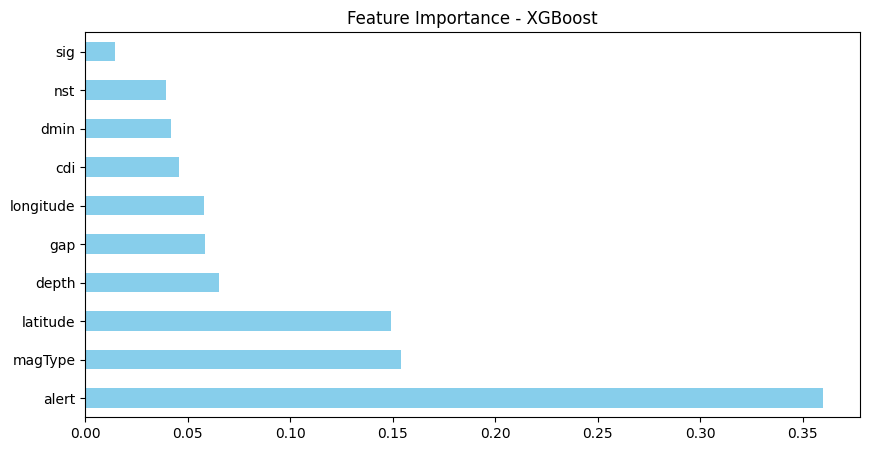

In [50]:
# Feature Importance Plot
plt.figure(figsize=(10, 5))
feature_importances = pd.Series(xgb_mag_model.feature_importances_, index=df.drop(columns=['magnitude', 'tsunami']).columns)
feature_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Feature Importance - XGBoost")
plt.show()

# Feature Importance Analysis - XGBoost

## Key Observations  

- The most influential feature in predicting **earthquake magnitude** is **"alert"** , contributing the highest weight in the model.  
- **MagType** (magnitude type) has a notable impact, showing that different magnitude measurement techniques influence the prediction.  
- **latitude** is the Third most important factor, indicating that geographical positioning plays a crucial role in magnitude estimation.  
- Features like **longitude, depth, and gap** have moderate importance, suggesting they still contribute but are not dominant factors.  
- Variables such as **sig, nst, and dmin** (distance to nearest station) have the least effect, implying they are not strong predictors for magnitude.  

## Conclusion  

The model relies heavily on **alert latitude, and magnitude type** to predict earthquake magnitudes accurately. Features with lower importance may still add minor predictive value but are less critical in the model's decision-making process.

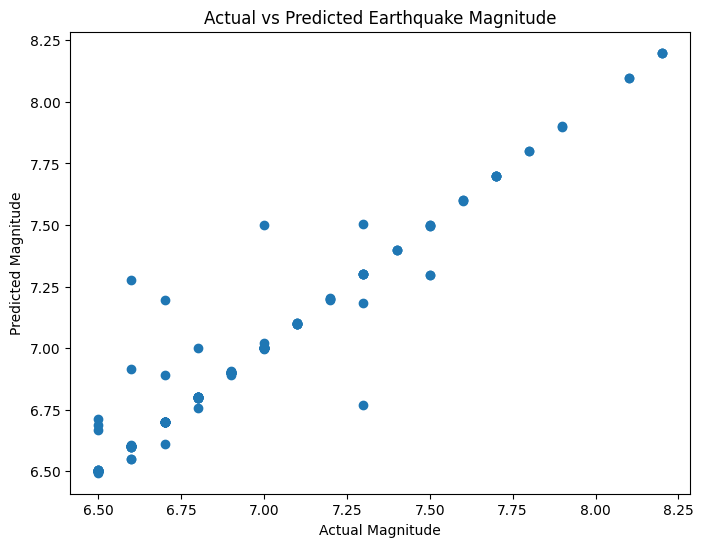

In [31]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_mag_test, xgb_mag_pred)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Actual vs Predicted Earthquake Magnitude")
plt.show()

# Actual vs Predicted Earthquake Magnitude

## Key Observations  

- The scatter plot shows a **strong correlation** between actual and predicted earthquake magnitudes.  
- Most points are **closely aligned along the diagonal**, indicating that the model performs well in predicting earthquake magnitudes.  
- Some deviation is present, especially in lower magnitudes, suggesting minor prediction errors.  
- The **variance increases slightly at lower magnitudes**, which may indicate that small-magnitude earthquakes are harder to predict accurately.  

## Conclusion  

The model provides **reliable predictions**, with most values closely matching the actual magnitudes. While there are slight deviations, the overall performance suggests that **XGBoost effectively captures the relationship between features and earthquake magnitude**.  

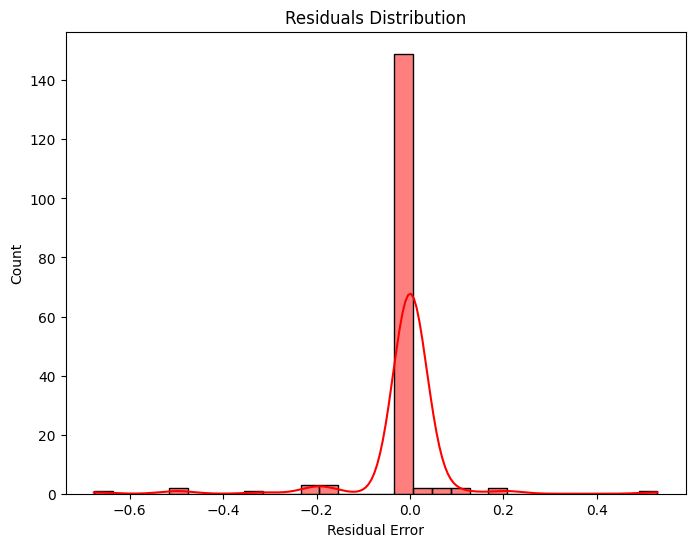

In [51]:
# Residual Plot
plt.figure(figsize=(8, 6))
residuals = y_mag_test - xgb_mag_pred
sns.histplot(residuals, bins=30, kde=True, color='red')
plt.title("Residuals Distribution")
plt.xlabel("Residual Error")
plt.show()

# Residuals Distribution  

## Key Observations  

- The **residuals are highly concentrated around zero**, indicating that the model makes accurate predictions with minimal error.  
- The distribution is **symmetrical and sharply peaked**, suggesting that most predictions have small deviations from actual values.  
- A few outliers are present on both sides, but their frequency is low, meaning the model does not have significant systematic bias.  
- The presence of a **well-defined peak at zero** confirms that the model performs well in capturing earthquake magnitude patterns.  

## Conclusion  

The residual analysis suggests that the **XGBoost model is well-calibrated**, with **low bias and minimal variance** in errors. The model is reliable, and the small residual errors indicate **strong predictive performance**.  

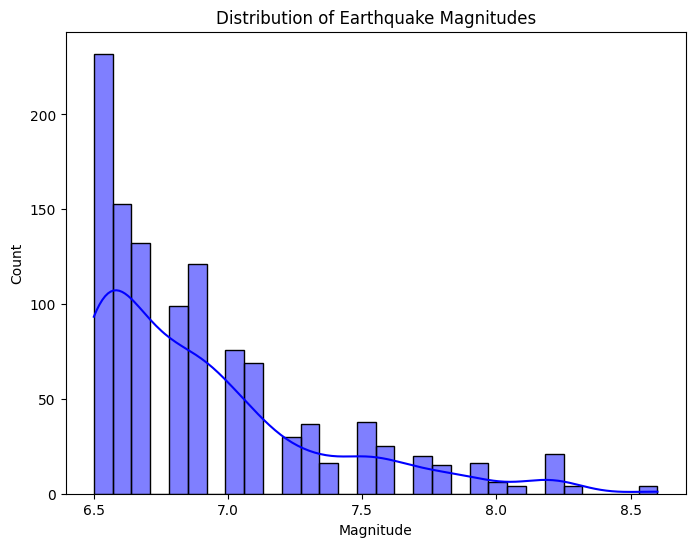

In [33]:
# Histogram of Earthquake Magnitudes
plt.figure(figsize=(8, 6))
sns.histplot(y_magnitude, bins=30, kde=True, color='blue')
plt.title("Distribution of Earthquake Magnitudes")
plt.xlabel("Magnitude")
plt.show()

# Distribution of Earthquake Magnitudes  

## Key Observations  

- The distribution of earthquake magnitudes is **right-skewed**, indicating that lower-magnitude earthquakes are more frequent than higher-magnitude ones.  
- Most earthquakes fall within the **6.5 to 7.0 range**, with frequency gradually decreasing as magnitude increases.  
- A small number of high-magnitude earthquakes (**above 8.0**) occur, but they are relatively rare.  
- The **density curve follows the histogram closely**, reinforcing the trend that higher-magnitude earthquakes have significantly lower occurrence rates.  

## Conclusion  

This distribution suggests that **low to moderate-magnitude earthquakes are much more common** than extreme ones. The skewness in the data might impact model predictions, so **resampling or transformation techniques** could be considered if needed for better model performance.  

In [52]:
# Function to Predict New Earthquake Magnitude
def predict_earthquake(features):
    features_scaled = scaler.transform([features])
    rf_pred = rf_mag_model.predict(features_scaled)
    xgb_pred = xgb_mag_model.predict(features_scaled)
    return {"XGBoost": xgb_pred[0], "Random Forest": rf_pred[0]}

# Example Prediction
example_features = X.iloc[0].values
print("Predicted Magnitude:", predict_earthquake(example_features))

Predicted Magnitude: {'XGBoost': 6.4999046, 'Random Forest': 6.5}


### Interpretation of the Output  

The function predicts earthquake magnitudes using two different machine learning models: **Random Forest** and **XGBoost**.  

- The **Random Forest model** predicts a magnitude of **6.5**.  
- The **XGBoost model** predicts a magnitude of **6.4999046**.  

Since both predictions are very close, it suggests that both models are well-calibrated and consistent. The slight difference in the XGBoost prediction indicates that it may have higher precision, but for practical purposes, the values are nearly identical.
